<img src="imgs/dh_logo_2.png" align="right" width="50%">

# Recomendação de Vídeos

[`Caracol TV`](https://www.caracoltv.com/) é líder no mercado de portais de notícias, esportes e entretenimento. São dezenas de milhões de acessos por dia em nossos portais, tendo cerca de 15 mil acessos por dia.

O objetivo do time de Personalização é melhorar a experiência dos usuários, fazendo com que eles encontrem o conteúdo que mais lhes agradem no site. 
Com isso, queremos aumentar o tempo de permanência e fidelidade dos usuários.

#### O problema

O desafio proposto consiste na recomendação de vídeos. Como fonte de dados, lhe fornecemos o
histórico de visualização de vídeos de cada usuário e os metadados dos vídeos
do acervo.

Existem dois arquivos com as informações necessárias:

- `videos.csv`: Contém uma linha para cada vídeo, com as seguintes colunas:
  - `video_id`: Id do vídeo
  - `programa_id`: Id do programa
  - `programa_titulo`: Título do programa
  - `programa_descricao`: Descrição do programa
  - `categoria`: Categoria do vídeo
  - `titulo`: Título do vídeo
  - `descricao`: Descrição do vídeo
  - `tags`: Tags do vídeo, separadas por ";"

- `video_views.csv`: Contém uma linha para cada par usuário/vídeo, com as seguintes colunas:
  - `usuario_id`: Id do usuário
  - `video_id`: Id do vídeo
  - `porcentagem_vista`: Porcentagem do vídeo vista pelo usuário. Valor é cumulativo.
  Pode ser maior que 1 se usuário viu o vídeo mais de uma vez.
  - `ultima_visualizacao`: Timestamp da última vez que o usuário viu o vídeo.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
df_views = pd.read_csv(
    r'C:\Users\LENOVO\Downloads\video_views (1)\video_views.csv',
    parse_dates=["ultima_visualizacao"],
    date_parser=lambda x: pd.to_datetime(x, unit="ms")
)

In [8]:
df_views.head()

,usuario_id,video_id,porcentagem_vista,ultima_visualizacao
0,f3c18ff17981963f,efac34dbae7d546f,1.866467,2014-12-05 16:24:02.643
1,ad7f9222659e9dbd,efac34dbae7d546f,0.799727,2014-12-04 12:27:39.807
2,3aca5ff7d0ccb963,efac34dbae7d546f,1.820864,2014-12-05 16:23:30.557
3,05055a341480a04f,efac34dbae7d546f,1.769413,2014-11-26 21:38:39.024
4,a2e8930c16ad6457,41a08a67dbd30f26,1.012109,2015-01-01 21:57:42.221


# Exploração

In [9]:
def plot_views(df):
    grouped = df.groupby("ultima_visualizacao")
    s = grouped["usuario_id"].count().resample("D").sum()
    s.plot()
    plt.ylabel("Visualizações por dia")

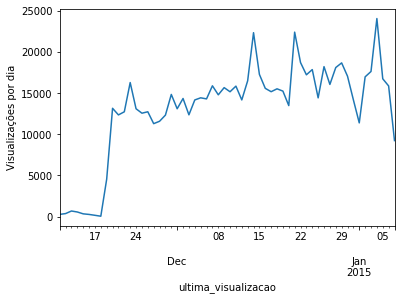

In [10]:
plot_views(df_views)

# Filtro na porcentagem de vistas

In [11]:
df_views.porcentagem_vista.describe()

count    759748.000000
mean          3.719851
std        2191.160438
min     -993339.101422
25%           0.190576
50%           0.980702
75%           1.452308
max      975493.667305
Name: porcentagem_vista, dtype: float64

In [7]:
mask = df_views.porcentagem_vista.between(0, 5)

df_views_clean = df_views[mask]

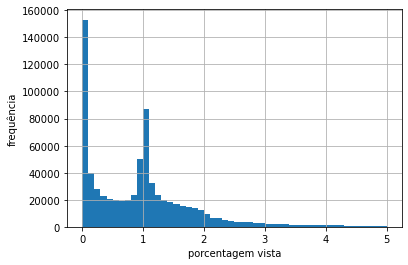

In [8]:
df_views_clean.porcentagem_vista.hist(bins=50)
plt.xlabel("porcentagem vista")
plt.ylabel("frequência");

# Janela no Timestamp

### Exercício

Definir uma função para filtrar o dataframe `df_views_clean` em uma determinada janela de tempo dada pela coluna `ultima_visualizacao`. A função deve ter os seguintes argumentos:

 - `df`: dataframe original
 - `t0`: data inicial
 - `days`: tamanho da janela em dias
 
A função deve retornar um novo dataframe com as mesmas colunas que o dataframe original.

Pode ser de utilidade a seguinte referência com manipulações de séries temporais no Pandas:

- [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)

### Solução

In [9]:
def time_window(df, t0, days):
    """ df: dataframe original
        t0: data inicial
        days: tamanho da janela em dias
        
        return df_masked  # masked dataframe
    """
    t = pd.to_datetime(t0)
    delta = pd.to_timedelta(days, 'D')
    mask = df.ultima_visualizacao.between(t, t+delta)
    df_masked = df[mask]
    return df_masked  # masked dataframe

### Verificação

In [10]:
df_new = time_window(df_views_clean, "2014-12-31", 10)

assert df_new.shape[0]==119878

# Vídeos mais populares

In [11]:
df_videos = pd.read_csv(
    r"data\videos.csv",
    index_col="video_id"
)

def ranking(df, t0, days):
    df_masked = time_window(df, t0, days)
    grouped = df_masked.groupby("video_id")
    s = grouped["porcentagem_vista"].sum()
    top_ten = s[:10].index
    return df_videos["titulo"][top_ten]

In [12]:
ranking(df_views_clean, "2014-12-31", 2)

video_id
002f93c111fb2ecc    Veja entrevista com Willem Dafoe e Mikhail Bar...
003d569418536241                      Magnolia Bakery e Guaraná Jesus
0046fbce7fefdb70                  UFC 160 - Junior Cigano x Mark Hunt
00667f90161d7649             Atol Majuro e Atol Arno - Ilhas Marshall
0068d27a61b700cf                                   Otavio - Sessão 01
0099afcd1f8d03aa                                    Universo do Samba
00a08371d9a4ea0b                                                Naldo
00a5aced5f09aae0                                                Dunga
00ad398d59812a73                Interior da França sobre quatro rodas
00c367ba1a1e1091          UFC 99 - Mirko Filipovic X Mostapha Al-Turk
Name: titulo, dtype: object

In [13]:
df_videos.loc["002f93c111fb2ecc"]["titulo"]

'Veja entrevista com Willem Dafoe e Mikhail Baryshnikov'

In [14]:
def pivoter(df, t0, days):
    df_masked = time_window(df, t0, days)
    df_pivot = df_masked.pivot(
        index="usuario_id",
        columns="video_id",
        values="porcentagem_vista"
    )
    return df_pivot


def recommender(df_pivot, video_id):
    s = df_pivot.corrwith(df_pivot[video_id]).sort_values()
    top_ten = s[:10].index
    return df_videos["titulo"][top_ten].tolist()

In [15]:
df_pivot = pivoter(df_views_clean, "2014-12-31", 10)

In [16]:
recommender(df_pivot, "002f93c111fb2ecc")

c:\users\jcrui\documents\work\envs\ml\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\jcrui\documents\work\envs\ml\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


['Veja entrevista com Willem Dafoe e Mikhail Baryshnikov',
 'Atura o Parabéns',
 'Frejat',
 'Magnolia Bakery e Guaraná Jesus',
 'UFC 48 - Frank Mir X Tim Sylvia',
 'Ulisses está desconfiado',
 'UFC 58 - Rich Franklin X David Loiseau',
 'UFC 160 - Junior Cigano x Mark Hunt',
 'Atol Majuro e Atol Arno - Ilhas Marshall',
 'Otavio - Sessão 01']